# Вариант 7
* X1 ~ N(-1, 2), n1 = 100
* X2 ~ R(-2, 0), n2 = 100

* σ1 = 2, (m1 – не изв.)

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.diagnostic import kstest_normal
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.proportion import binom_test
from statsmodels.stats.proportion import proportion_confint

import math

In [4]:
from typing import Dict

## Исходные данные

In [5]:
n1 = 100
n2 = 100

norm = st.distributions.norm(-1, 2).rvs(100, random_state=42)
uniform = st.distributions.uniform(-2, 0).rvs(100, random_state=42)

In [6]:
def describe_distribution(distribution, name) -> Dict[str, Dict[str, float]]:
    description = st.describe(distribution)

    return {
            name: {
                      'mean': description[2],
                      'variance': description[3],
                      'deviation': np.sqrt(description[3])
                  }
           }

def calc_pooled_distribution(d1, name1, d2, name2) -> Dict[str, Dict[str, float]]:
    description_d1 = describe_distribution(d1, name1)
    description_d2 = describe_distribution(d2, name2)

    return {
            f'{name1}/{name2}': {
                      'mean': (description_d1[name1]['mean'] * d1.shape[0] + description_d2[name2]['mean'] * d2.shape[0]) / (d1.shape[0] + d2.shape[0]),
                      'variance': (description_d1[name1]['variance'] * (d1.shape[0] - 1) + description_d2[name2]['variance'] * (d2.shape[0] - 1)) / (d1.shape[0] + d2.shape[0] - 2),
                      'deviation': np.sqrt((description_d1[name1]['variance'] * (d1.shape[0] - 1) + description_d2[name2]['variance'] * (d2.shape[0] - 1)) / (d1.shape[0] + d2.shape[0] - 2))
              }
           }

In [7]:
print(describe_distribution(norm, 'normal'))

{'normal': {'mean': -1.2076930347881878, 'variance': 3.2990795745206403, 'deviation': 1.8163368560156017}}


In [8]:
describe_distribution(uniform, 'uniform')

<ipython-input-6-ed3209fe0a5d>:2: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  description = st.describe(distribution)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1405: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = skew(a, axis, bias=bias)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1406: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(a, axis, bias=bias)


{'uniform': {'mean': -2.0, 'variance': 0.0, 'deviation': 0.0}}

In [9]:
# Pooled

calc_pooled_distribution(norm, 'normal', uniform, 'uniform')

<ipython-input-6-ed3209fe0a5d>:2: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  description = st.describe(distribution)


{'normal/uniform': {'mean': -1.6038465173940937,
  'variance': 1.64953978726032,
  'deviation': 1.2843441078076856}}

## Однопараметрические критерии

100


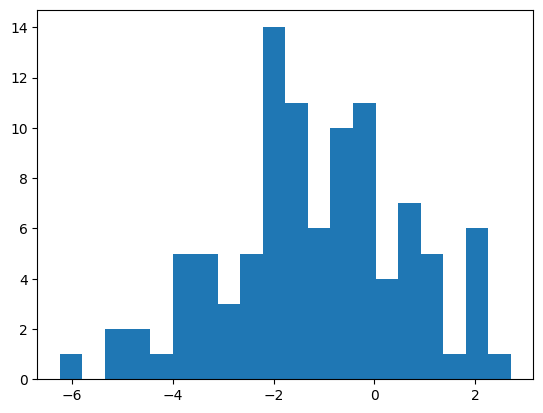

In [10]:
(plt.hist(norm, bins=20), norm.shape[0]);
print(norm.shape[0])

In [65]:
hypothesis = {"z_test" : -1.4, "t_test": -1, "chi_estim": 3.2, "chi_notestim": 3.2}

def chi_squared_variance(distribution: np.array, s0, ddof=0):
    z = ((distribution.shape[0] - ddof) * distribution.var(ddof=1)) / s0
    f = st.chi2.cdf(z, distribution.shape[0] - ddof)
    return {"statistic" : z, "pvalue" : min(f, 1-f) / 2}

def single_parameters_test(distribution, hyp):
      ztest_tuple = ztest(distribution, value=hyp["z_test"])
      ttest_tuple = st.ttest_1samp(distribution, hyp["t_test"])
      return {
                "z_test": {'statistic': ztest_tuple[0], 'pvalue': min(ztest_tuple[1], 1-ztest_tuple[1]) / 2},
                "t_test": {'statistic': ttest_tuple[0], 'pvalue': min(ttest_tuple[1], 1-ttest_tuple[1]) / 2},
                "chi_unknow_mean": chi_squared_variance(norm, hypothesis['chi_notestim']),
                "chi_known_mean": chi_squared_variance(norm, hypothesis['chi_estim'], ddof=1)
             }

In [63]:
single_parameters_test(norm, hypothesis)

{'z_test': {'statistic': 1.0587626660489913, 'pvalue': 0.14485394014692304},
 't_test': {'statistic': -1.143472005758847, 'pvalue': 0.12780008812651783},
 'chi_unknow_mean': {'statistic': 103.09623670377,
  'pvalue': 0.19799120132711584},
 'chi_known_mean': {'statistic': 102.0652743367323,
  'pvalue': 0.1981547980474314}}

## Двухвыборочные критерии

In [13]:
st.ttest_ind(norm, uniform)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


TtestResult(statistic=4.36211467376075, pvalue=2.070935766726985e-05, df=198.0)

In [14]:
def ftest(dst1, dst2, ddof=0):
    f = st.f(dst1.shape[0] - ddof, dst2.shape[0] - ddof).cdf
    return {'statistic' : (z := dst1.var() / dst2.var()), 'pvalue': min(1 - f(z), f(z)) / 2}

In [15]:
ftest(uniform, norm, 1)

{'statistic': 0.0, 'pvalue': 0.0}

In [16]:
ftest(uniform, norm)

{'statistic': 0.0, 'pvalue': 0.0}

### Исследование распределений статистик критерия

$$s_{1} = 2$$

$$m_{1} - неизв$$

In [67]:
N = 1000
d_h = 4

z_values, p_values = [], []

for i in range(N):
    distribution = st.distributions.norm(-1, 2).rvs(100)
    z, _ = chi_squared_variance(distribution, d_h).values()
    p = st.chi2.cdf(z, distribution.shape[0] - 1) * 2
    z_values.append(z)
    p_values.append(p)

In [68]:
describe_distribution(z_values, 'z'), describe_distribution(p_values, 'p')

({'z': {'mean': 99.83799558694653,
   'variance': 191.36334546059516,
   'deviation': 13.8334140927175}},
 {'p': {'mean': 0.5188881172743218,
   'variance': 0.082057911557731,
   'deviation': 0.2864575213844646}})

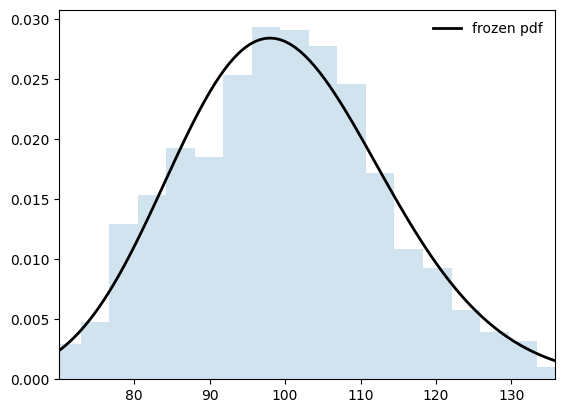

In [69]:
fig, ax = plt.subplots(1, 1)
df = 100
x = np.linspace(st.chi2.ppf(0.01, df),
                st.chi2.ppf(0.99, df), 100)

rv = st.chi2(df)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
ax.hist(z_values, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax.set_xlim([x[0], x[-1]])
ax.legend(loc='best', frameon=False)
plt.show()

(array([1.00261466, 0.89243722, 0.90345497, 0.89243722, 0.85938399,
        1.07973886, 1.02465015, 1.15686307, 1.14584532, 1.0136324 ,
        1.04668563]),
 array([0.00114627, 0.09190896, 0.18267165, 0.27343433, 0.36419702,
        0.45495971, 0.54572239, 0.63648508, 0.72724777, 0.81801045,
        0.90877314, 0.99953583]),
 [<matplotlib.patches.Polygon at 0x7b6380897dc0>])

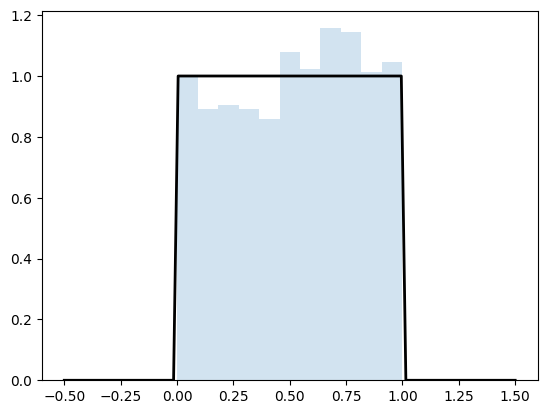

In [73]:
fig, ax = plt.subplots(1, 1)
df = 100
x = np.linspace(-0.5, 1.5, 100)

rv = st.uniform(loc=0, scale=1)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
ax.hist(p_values, density=True, bins='auto', histtype='stepfilled', alpha=0.2)